# Exploratory Data Analysis Humanware Project (Block 1)

The following notebook will cover and EDA for the first part of the humanware project. The data exploration is based on the public SVHN library. The transforms made to the images follow the guidelines stated on the paper [*Multi-digit Number Recognition from Street View Imagery using Deep Convolutional Neural Networks*](https://arxiv.org/abs/1312.6082). 

#### Imports

In [2]:
import os
import sys
import pickle
import pprint
import math

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from processing.transforms import BoundingBoxCrop, Rescale, RandomCrop

plt.style.use('bmh')
%matplotlib inline

#### Helper functions

In [3]:
def plot_image(image, metadata=None, is_path=True):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if is_path:
        image = Image.open(image)
    ax.imshow(image)
    if metadata:
        top = metadata.get('top')
        left = metadata.get('left')
        height = metadata.get('height')
        width = metadata.get('width')
        for idx, label in enumerate(metadata.get('label')):
            rect = patches.Rectangle((left[idx], top[idx]), width[idx], height[idx],
                                     linewidth=1, edgecolor='r', facecolor='none', clip_on=False)
            ax.add_patch(rect)
            ax.text(left[idx]+width[idx]/2, top[idx]+height[idx]/2, '{}'.format(label), color='red',
                    horizontalalignment='center', verticalalignment='center')
    plt.tight_layout()
    plt.axis('off')
    plt.show()

def plot_grid(img_dir, list_image_data, figsize=(15, 6)):
    ncols = int(math.sqrt(len(list_image_data)))
    nrows = math.ceil(len(list_image_data)/ncols)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, facecolor='w', edgecolor='k')
    axs = axs.ravel()
    for idx_img, data in enumerate(list_image_data):
        if not 'image' in data:
            image = Image.open(os.path.join(img_dir, data.get('filename')))
        else:
            image = data.get('image')
        axs[idx_img].imshow(image)
        metadata = data.get('metadata', {})
        if metadata:
            top = metadata.get('top')
            left = metadata.get('left')
            height = metadata.get('height')
            width = metadata.get('width')
            for idx, label in enumerate(metadata.get('label')):
                rect = patches.Rectangle((left[idx], top[idx]), width[idx], height[idx],
                                         linewidth=1, edgecolor='r', facecolor='none', clip_on=False)
                axs[idx_img].add_patch(rect)
                axs[idx_img].text(left[idx]+width[idx]/2, top[idx]+height[idx]/2, '{}'.format(label), color='red',
                                  horizontalalignment='center', verticalalignment='center')
    plt.tight_layout()
    plt.show();

#### Read annotations and define images path

For more information on loading the data and an annotation example go to humanware data directory [here](https://github.com/mila-udem/ift6759/tree/master/projects/humanware/data).

In [4]:
# Change the paths according to project structure
pickle_path = os.path.join('..', '..', 'digit-detection', 'data', 'SVHN', 'train_metadata.pkl')
image_dir = os.path.join('..', '..', 'digit-detection', 'data', 'SVHN', 'train')

with open(pickle_path, 'rb') as annotation_file:
    annotations = pickle.load(annotation_file)

#### Sample annotation and image

{   'height': [32, 32],
    'label': [2, 3],
    'left': [77, 98],
    'top': [29, 25],
    'width': [23, 26]}


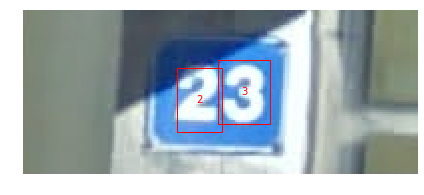

In [5]:
# Define pretty printer
pp = pprint.PrettyPrinter(indent=4)

# Get annotations and image name for idx 1 
information_idx_1 = annotations.get(1)
image_filename = information_idx_1.get('filename')
metadata = information_idx_1.get('metadata')

# Print annotations
pp.pprint(metadata)

# Show image
plot_image(os.path.join(image_dir, image_filename), metadata)

#### General statistics

In [6]:
# Number of images on train
print('The number of images on the train set is {}'.format(len(annotations)))

The number of images on the train set is 33402


The number of images with 2 number(s) is: 18130
The number of images with 3 number(s) is: 8691
The number of images with 1 number(s) is: 5137
The number of images with 4 number(s) is: 1434
The number of images with 5 number(s) is: 10


[Text(0, 0.5, 'Images'),
 Text(0.5, 0, 'Count of numbers'),
 Text(0.5, 1.0, 'Number of labels per image on train')]

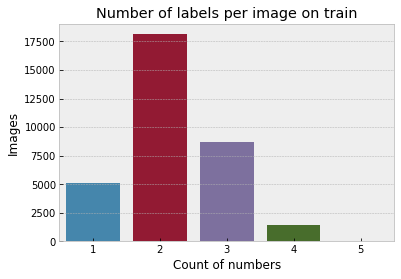

In [9]:
# Number of labels per image
count = {}
for value in annotations.values():
    metadata = value.get('metadata', 0)
    labels = len(metadata.get('label', []))
    labels = min(labels, 5)
    count.setdefault(labels, 0)
    count[labels] += 1

for (key, value) in count.items():
    print('The number of images with {} number(s) is: {}'.format(key, value))
    
df = pd.DataFrame.from_dict({'numbers': list(count.keys()), 'count': list(count.values())})
ax = sns.barplot(x='numbers', y='count', data=df)
ax.set(xlabel='Count of numbers', ylabel='Images', title='Number of labels per image on train')

The number 1 appears 13861 times
The number 9 appears 4659 times
The number 2 appears 10585 times
The number 3 appears 8497 times
The number 5 appears 6882 times
The number 8 appears 5045 times
The number 7 appears 5595 times
The number 4 appears 7458 times
The number 6 appears 5727 times
The number 0 appears 4948 times


[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Number'),
 Text(0.5, 1.0, 'Count of each number on train')]

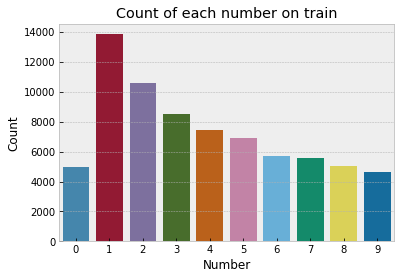

In [10]:
# Most common numbers
count = {}
for value in annotations.values():
    metadata = value.get('metadata', 0)
    labels = metadata.get('label', [])
    for label in labels:
        count.setdefault(label, 0)
        count[label] += 1

for (key, value) in count.items():
    print('The number {} appears {} times'.format(key, value))
    
df = pd.DataFrame.from_dict({'number': list(count.keys()), 'count': list(count.values())})
ax = sns.barplot(x='number', y='count', data=df)
ax.set(xlabel='Number', ylabel='Count', title='Count of each number on train')

#### Transforms

The following section describes the transforms applied to the images in the pipeline. The order of the pipeline is:
1. **Original images**
2. **Crop around the section that encompasses all bounding boxes + margin**
3. **Rescale**
4. **RandomCrop**

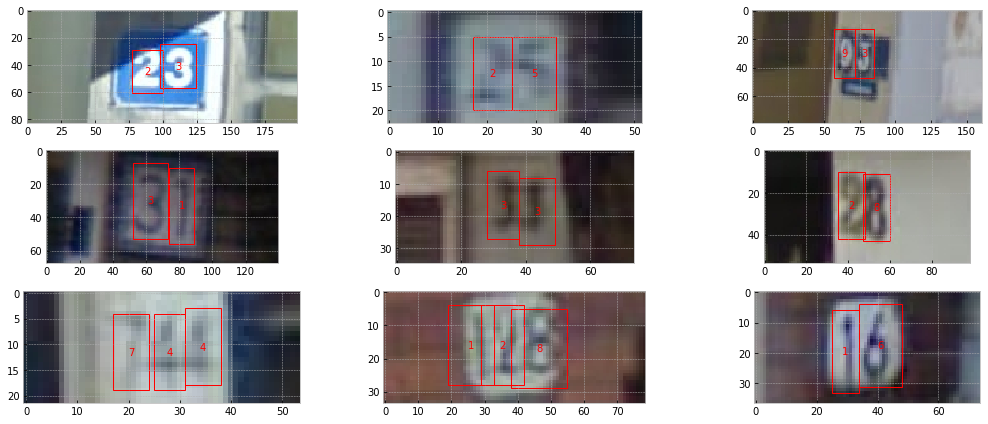

In [11]:
plot_grid(image_dir, [annotations[x] for x in range(1, 10)])

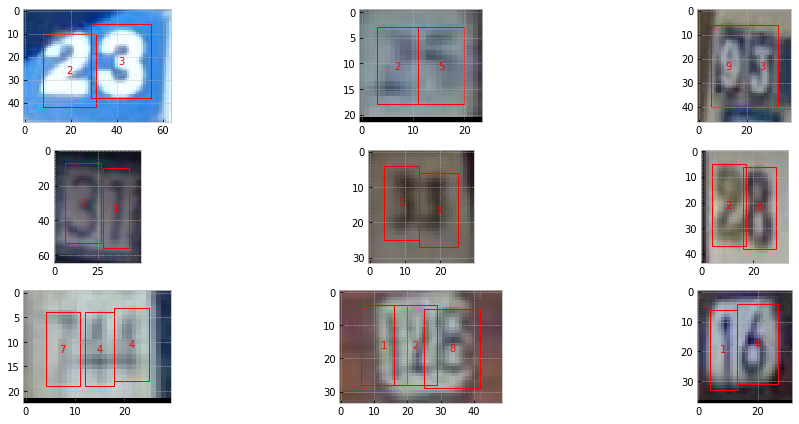

In [12]:
bbcrop = BoundingBoxCrop(margin=0.3)
list_ = [bbcrop(Image.open(os.path.join(image_dir, annotations[x].get('filename'))), annotations[x].get('metadata')) for x in range(1, 10)]
plot_grid(image_dir, [{'image': image, 'metadata': metadata} for image, metadata in list_])

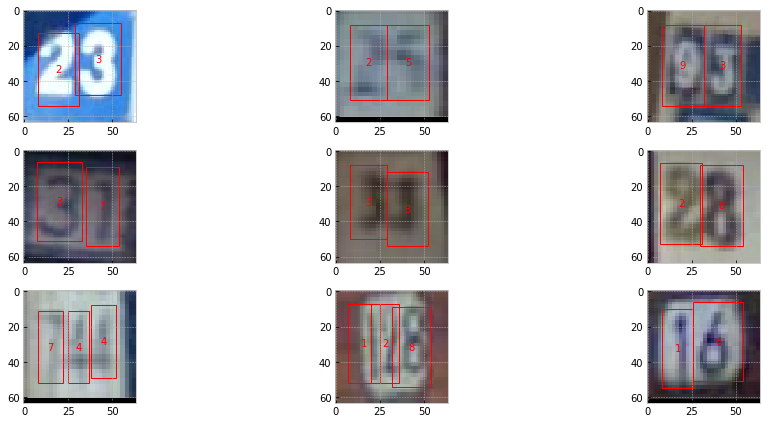

In [13]:
rescale = Rescale((64, 64))
list_ = [rescale(image, metadata) for image, metadata in list_]
plot_grid(image_dir, [{'image': image, 'metadata': metadata} for image, metadata in list_])

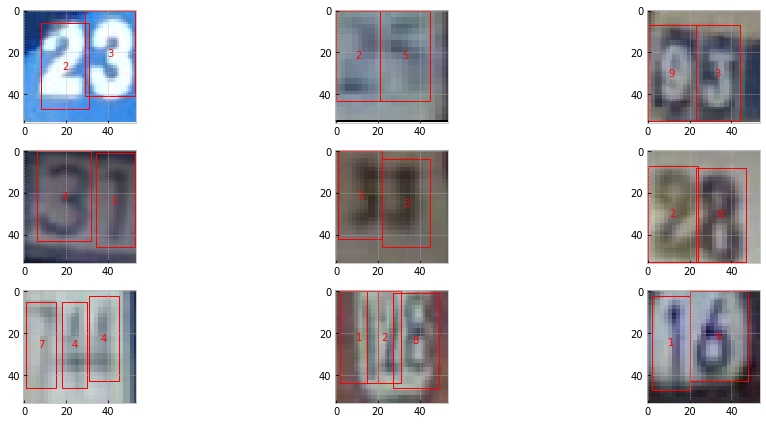

In [14]:
rcrop = RandomCrop((54, 54))
list_ = [rcrop(image, metadata) for image, metadata in list_]
plot_grid(image_dir, [{'image': image, 'metadata': metadata} for image, metadata in list_])

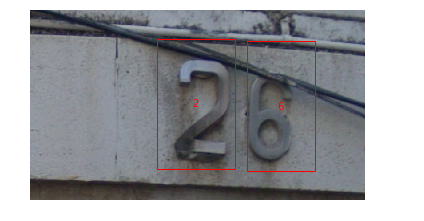

In [15]:
information_idx_410 = annotations.get(410)
image_filename = information_idx_410.get('filename')
metadata = information_idx_410.get('metadata')
image = Image.open(os.path.join(image_dir, image_filename))
plot_image(image, metadata, is_path=False)

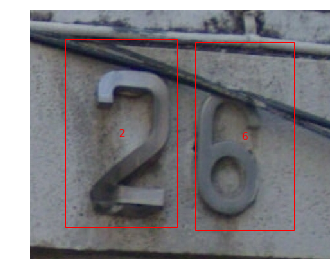

In [16]:
image, metadata = bbcrop(image, metadata)
plot_image(image, metadata, is_path=False)

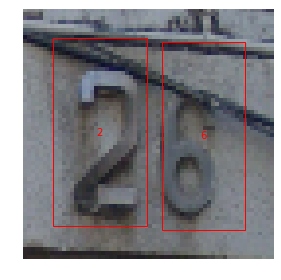

In [17]:
image, metadata = rescale(image, metadata)
plot_image(image, metadata, is_path=False)

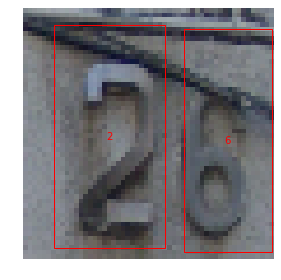

In [18]:
image, metadata = rcrop(image, metadata)
plot_image(image, metadata, is_path=False)